In [ ]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dirve_dir_data = "/content/drive/My Drive/MIE363_CaseStudy"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df_prod = pd.read_excel(dirve_dir_data + "/Prod5.xlsx", sheet_name= "all")   

In [ ]:
df_prod.dtypes

Date                      datetime64[ns]
Product_Name                      object
Category_Name                     object
ActualShipmentInCases              int64
PricePerCase                       int64
Retail_POS_Sales_Units           float64
Retail_POS_Sales_Cases           float64
Retail_Inventory                 float64
AveragePrice                     float64
Week_Number                        int64
Week_Index                         int64
dtype: object

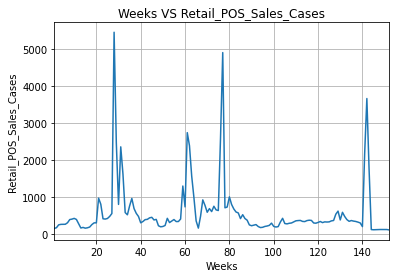

In [ ]:
plt.title('Weeks VS Retail_POS_Sales_Cases')
plt.ylabel('Retail_POS_Sales_Cases')
plt.xlabel('Weeks')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot( df_prod['Week_Index'], df_prod['Retail_POS_Sales_Cases'])

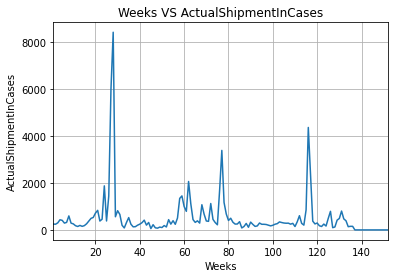

In [ ]:
plt.title('Weeks VS ActualShipmentInCases')
plt.ylabel('ActualShipmentInCases')
plt.xlabel('Weeks')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot( df_prod['Week_Index'], df_prod['ActualShipmentInCases'])

##Split

In [ ]:
rawdata = df_prod['Retail_POS_Sales_Cases']
train_data = rawdata
# test_data_size = 30
# train_data = rawdata[:-test_data_size]
# test_data = rawdata[-test_data_size:]
print(rawdata)

0      158.5725
1      177.3750
2      255.0750
3      267.8400
4      269.9400
         ...   
147    128.7600
148    127.8450
149    126.2550
150    128.1750
151    117.9525
Name: Retail_POS_Sales_Cases, Length: 152, dtype: float64


## Data Processing

In [ ]:
np.random.seed(1000)
clean_signal = rawdata
mus = [15,5,10]
sigmas = [3,2,5]
new_data = []
for mu in mus:
  for sigma in sigmas:
    noise = np.random.normal(mu, sigma, len(clean_signal))
    signal = clean_signal + noise
    print(set(clean_signal) == set(signal))
    new_data.append(signal)


False
False
False
False
False
False
False
False
False


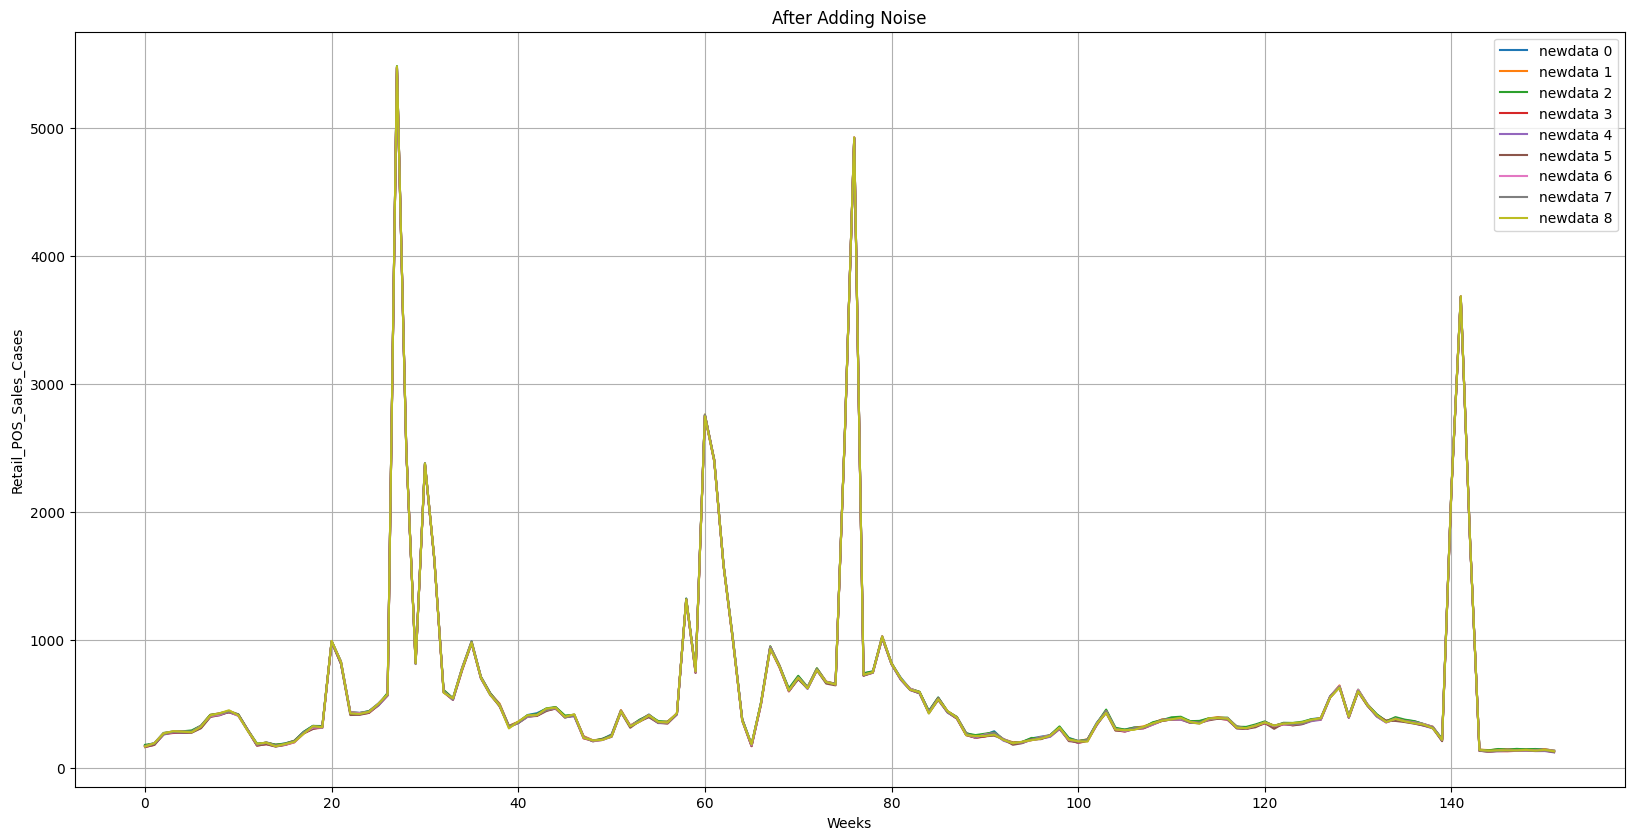

In [ ]:
y = new_data
fig,ax = plt.subplots(figsize=(20,10), dpi=100)
# ax.scatter(z1_sol, z2_sol,c = 'r', s = 10)
for i in range(len(y)):
    ax.plot(y[i],label = 'newdata %s'%i)
plt.title('After Adding Noise')
plt.ylabel('Retail_POS_Sales_Cases')
plt.xlabel('Weeks')
plt.grid(True)
plt.legend(loc='best')
plt.show()

##Normolize data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

In [ ]:
data = []
normolized_data = []
for i in range(len(new_data)):
  train_data_arg1 = new_data[i]
  scaler = MinMaxScaler(feature_range=(-1, 1))
  train_data_arg1_normalized = scaler.fit_transform(train_data_arg1.values.reshape(-1, 1))
  data.extend(train_data_arg1)
  normolized_data.extend(train_data_arg1_normalized)
data.extend(rawdata)
normolized_data.extend(train_data_normalized)

In [ ]:
# to tensor 
data_normalized_tensor = torch.FloatTensor(normolized_data).view(-1)
data_tensor = torch.FloatTensor(data).view(-1)


In [ ]:
print(len(data_tensor))

1520


## Input sequences

In [ ]:
#generate input to feed into model as well as label 
def generate_input_sequences(input_data, tw, label_len):
    input_sequences = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+label_len]
        input_sequences.append((train_seq ,train_label))
    return input_sequences

In [ ]:
def get_train_val(data_tensor, train_window , label_len):
  total_seq = generate_input_sequences(data_tensor, train_window, label_len)
  actual_input = []
  for item in total_seq:
    seq, labels = item
    if len(labels) == label_len :
      actual_input.append((seq, labels))
  print(len(actual_input), len(total_seq))
  import random
  random.seed(1000)
  random.shuffle(actual_input)
  split = int(len(actual_input) * 0.8)
  train_input_seq = actual_input[:split]
  val_input_seq = actual_input[split:]
  print(len(train_input_seq))
  print(len(val_input_seq))
  return train_input_seq, val_input_seq

##Model:
input_size=1, each week have only 1 value

hidden_layer_size=100, 

output_size=4, predicitng number of sales in 4 weeks

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=4):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
class LSTM_medium(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=4):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
class LSTM_large(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=200, output_size=4):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
class ANN26(nn.Module):
    def __init__(self):
        super(ANN26, self).__init__()
        self.fc1 = nn.Linear(26, 15)
        self.fc2 = nn.Linear(15, 10)
        self.fc3 = nn.Linear(10, 4)

    def forward(self, x):
        x = x.view(-1,26)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x.squeeze()

In [ ]:
def get_loss(model, train_input):
  error = 0
  for seq, labels in train_input:
    model_preds = model(seq)
    # print(model_preds)
    for i in range(len(model_preds)):
      model_pred = float(model_preds[i])
      truth = float(labels[i])
      error += abs(model_pred - truth)
  total_mad = error / ( len(train_input) * 4 )
  return total_mad 


In [ ]:
dirve_dir_model = "/content/drive/My Drive/MIE363_CaseStudy/LSTM/"
def train(model, train_input, val_input, learning_rate =0.001, num_epochs=30, name="rnn"):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    epoches, train_loss, val_loss = [], [], []
    for i in range(num_epochs):
      for seq, labels in train_input:
        optimizer.zero_grad()
        # print("blablab")
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        
        y_pred = model(seq)
        # print(y_pred)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
      train_loss.append(get_loss(model, train_input))
      val_loss.append(get_loss(model, val_input))
      epoches.append(i)
      if i % 5 == 0:
        model_path = dirve_dir_model + "Prod5_Epoch" + str(i) + name 
        torch.save(model.state_dict(), model_path)
        print("train_mad: ", i, " ", train_loss[-1])
      elif num_epochs - i < 3:
        model_path = dirve_dir_model + "Prod5_Epoch" + str(i) + name 
        torch.save(model.state_dict(), model_path)
        print("train_mad: ", i, " ", train_loss[-1])

       
    # plotting
    plt.title("Training Curve")
    plt.plot(epoches, train_loss, label="Train")
    plt.plot(epoches, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("MAD")
    plt.legend(loc='best')
    plt.show()





In [ ]:
dirve_dir_model = "/content/drive/My Drive/MIE363_CaseStudy/LSTM/"
def trainANN(model, train_input, val_input, learning_rate =0.001, num_epochs=30, name="ann" ):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    epoches, train_loss, val_loss = [], [], []
    for i in range(num_epochs):
      for seq, labels in train_input:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
      train_loss.append(get_loss(model, train_input))
      val_loss.append(get_loss(model, val_input))
      epoches.append(i)
      if i % 5 == 0:
        model_path = dirve_dir_model + "Prod5_Epoch" + str(i) + name 
        torch.save(model.state_dict(), model_path)
        print("train_mad: ", i, " ", train_loss[-1])
      elif num_epochs - i < 3:
        model_path = dirve_dir_model + "Prod5_Epoch" + str(i) + name 
        torch.save(model.state_dict(), model_path)
        print("train_mad: ", i, " ", train_loss[-1])
       
    # plotting
    plt.title("Training Curve")
    plt.plot(epoches, train_loss, label="Train")
    plt.plot(epoches, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("MAD")
    plt.legend(loc='best')
    plt.show()


## RNN

input = 26 

In [ ]:
train_input_seq, val_input_seq = get_train_val(data_tensor, 26 , 4)

1491 1494
1192
299


train_mad:  0   392.4933864213401
train_mad:  5   375.6496232866291
train_mad:  10   369.43623514403436
train_mad:  15   314.944297670968
train_mad:  20   304.7267477456355
train_mad:  25   279.4187585776484
train_mad:  30   255.7976076121398
train_mad:  35   240.8152417010509
train_mad:  40   225.3676338710591
train_mad:  45   221.10570392932667
train_mad:  48   222.83950862004704
train_mad:  49   206.43606623734703


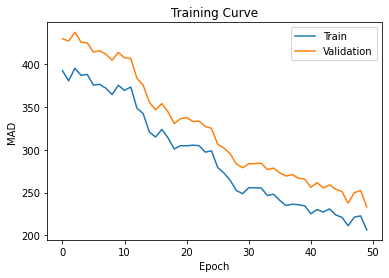

In [ ]:
model_ann = ANN26()
trainANN(model_ann, train_input_seq, val_input_seq, learning_rate =0.001, num_epochs= 50, name = "ann26")

train_mad:  0   459.651898176078
train_mad:  5   310.7304991459686
train_mad:  10   324.7832125081312
train_mad:  13   332.47683127614476
train_mad:  14   328.45428569844904


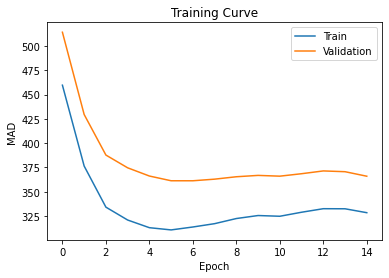

In [ ]:
model_lstm_large = LSTM_large()
train(model_lstm_large, train_input_seq, val_input_seq, learning_rate =0.001, num_epochs= 15, name = "large26")

normolized data

1491 1494
1192
299
train_mad:  0   0.8522093971220827
train_mad:  5   0.8522093971220827
train_mad:  10   0.8522093971220827
train_mad:  15   0.8522093971220827
train_mad:  20   0.8522093971220827
train_mad:  25   0.8522093971220827
train_mad:  28   0.8522093971220827
train_mad:  29   0.8522093971220827


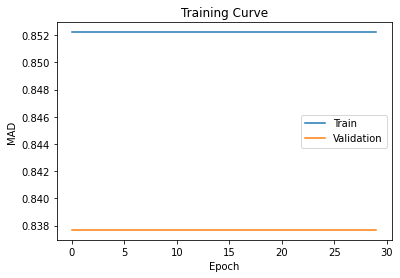

In [ ]:
train_norminput_seq, val_norminput_seq = get_train_val(data_normalized_tensor, 26 , 4)
model_ann = ANN26()
trainANN(model_ann, train_norminput_seq, val_norminput_seq, learning_rate =0.005, num_epochs= 30, name = "ann26norm")

train_mad:  0   0.20255015286751366
train_mad:  5   0.18921964993425364
train_mad:  10   0.11547903977053227
train_mad:  13   0.09267980449101669
train_mad:  14   0.09646379570718917


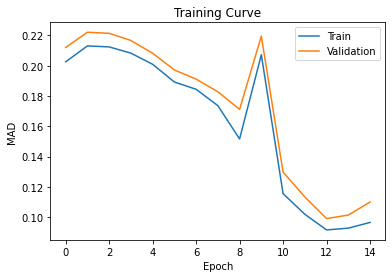

In [ ]:
model_lstm_large = LSTM_large()
train(model_lstm_large, train_norminput_seq, val_norminput_seq, learning_rate =0.001, num_epochs= 15, name = "large26norm")

input = 52

In [ ]:
class ANN52(nn.Module):
    def __init__(self):
        super(ANN52, self).__init__()
        self.fc1 = nn.Linear(52, 30)
        self.fc2 = nn.Linear(30, 10)
        self.fc3 = nn.Linear(10, 4)

    def forward(self, x):
        x = x.view(-1,52)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x.squeeze()

1465 1468
1172
293
train_mad:  0   332.97091672526284
train_mad:  5   225.4480623362821
train_mad:  10   217.48538202291462
train_mad:  15   208.04907613275606
train_mad:  20   154.55102718883407
train_mad:  25   144.7440633692432
train_mad:  30   214.37027376412124
train_mad:  35   137.1808674089331
train_mad:  40   194.27905924002872
train_mad:  45   209.4952957662706
train_mad:  48   188.67440432381304
train_mad:  49   191.5954499160267


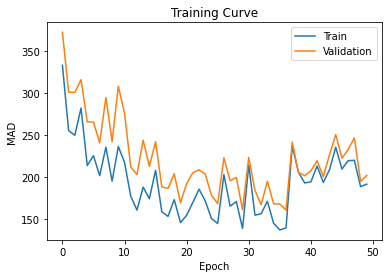

train_mad:  0   516.289309853173
train_mad:  5   329.05462145561245
train_mad:  10   310.0321588483687
train_mad:  15   318.4508456923449
train_mad:  18   313.6799379485459
train_mad:  19   327.16752423035814


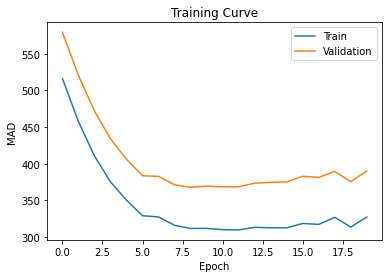

In [ ]:
train_input_seq, val_input_seq = get_train_val(data_tensor, 52 , 4)
model_ann = ANN52()
trainANN(model_ann, train_input_seq, val_input_seq, learning_rate =0.005, num_epochs= 50, name = "ann520.05")
model_lstm = LSTM()
train(model_lstm, train_input_seq, val_input_seq, learning_rate =0.001, num_epochs= 20, name = "reg52")

1465 1468
1172
293
train_mad:  0   0.8533606221722582
train_mad:  5   0.8533606221722582
train_mad:  10   0.8533606221722582
train_mad:  15   0.8533606221722582
train_mad:  20   0.8533606221722582
train_mad:  25   0.8533606221722582
train_mad:  30   0.8533606221722582
train_mad:  35   0.8533606221722582
train_mad:  40   0.8533606221722582
train_mad:  45   0.8533606221722582
train_mad:  50   0.8533606221722582
train_mad:  55   0.8533606221722582
train_mad:  58   0.8533606221722582
train_mad:  59   0.8533606221722582


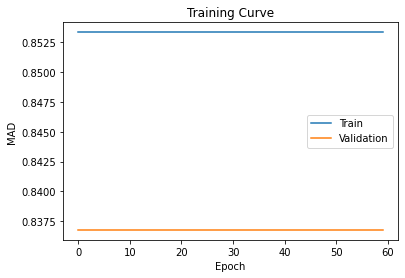

train_mad:  0   0.1320511573568422
train_mad:  5   0.13505963870715954
train_mad:  10   0.12485501517437608
train_mad:  11   0.13483438874319126


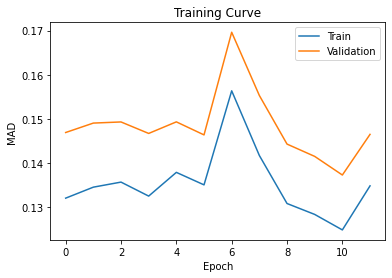

In [ ]:
train_input_seq, val_input_seq = get_train_val(data_normalized_tensor, 52 , 4)
model_ann = ANN52()
trainANN(model_ann, train_input_seq, val_input_seq, learning_rate =0.005, num_epochs= 60, name = "ann52norm")
model_lstm_large = LSTM_large()
train(model_lstm_large, train_input_seq, val_input_seq, learning_rate =0.005, num_epochs= 12, name = "large52norm")

inout = 104

In [ ]:
class ANN104(nn.Module):
    def __init__(self):
        super(ANN104, self).__init__()
        self.fc1 = nn.Linear(104, 60)
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 10)
        self.fc4 = nn.Linear(10, 4)

    def forward(self, x):
        x = x.view(-1,104)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x.squeeze()

1413 1416
1130
283
train_mad:  0   451.2158673083888
train_mad:  5   278.7679066843691
train_mad:  10   263.5267543412943
train_mad:  15   251.94248451131634
train_mad:  20   235.30808091627813
train_mad:  25   244.5444955775168
train_mad:  30   227.52630669078997
train_mad:  35   300.19964868494895
train_mad:  40   261.69815149222853
train_mad:  45   219.97439019701122
train_mad:  48   183.84395311490624
train_mad:  49   177.02514514944195


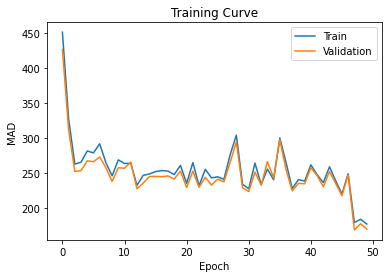

train_mad:  0   532.8449089489152
train_mad:  5   345.12222127661244
train_mad:  10   320.6809198058812
train_mad:  15   334.40400307579375
train_mad:  18   334.75119758200856
train_mad:  19   336.90947998857075


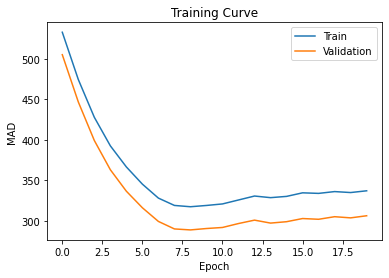

In [ ]:
train_input_seq, val_input_seq = get_train_val(data_tensor, 104 , 4)
model_ann = ANN104()
trainANN(model_ann, train_input_seq, val_input_seq, learning_rate =0.005, num_epochs= 50, name = "ann520.05")
model_lstm = LSTM()
train(model_lstm, train_input_seq, val_input_seq, learning_rate =0.001, num_epochs= 20, name = "reg52")

1413 1416
1130
283
train_mad:  0   0.8520632664652426
train_mad:  5   0.8520632664652426
train_mad:  10   0.8520632664652426
train_mad:  15   0.8520632664652426
train_mad:  20   0.8520632664652426
train_mad:  25   0.8520632664652426
train_mad:  30   0.8520632664652426
train_mad:  35   0.8520632664652426
train_mad:  40   0.8520632664652426
train_mad:  45   0.8520632664652426
train_mad:  50   0.8520632664652426
train_mad:  55   0.8520632664652426
train_mad:  58   0.8520632664652426
train_mad:  59   0.8520632664652426


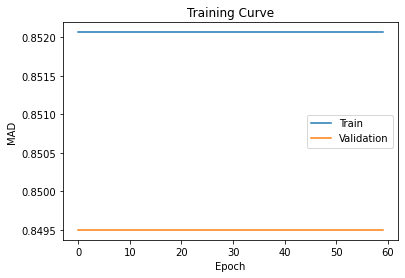

train_mad:  0   0.18582658432712532
train_mad:  5   0.14818901762456954
train_mad:  8   0.14482181304117944
train_mad:  9   0.13982161937808965


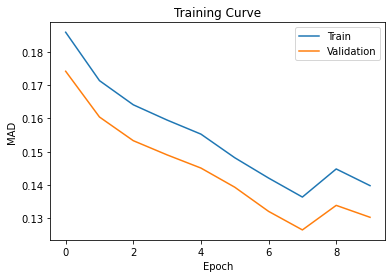

In [ ]:
train_input_seq, val_input_seq = get_train_val(data_normalized_tensor, 104 , 4)
model_ann = ANN104()
trainANN(model_ann, train_input_seq, val_input_seq, learning_rate =0.001, num_epochs= 60, name = "ann104norm")
model_lstm_large = LSTM_large()
train(model_lstm_large, train_input_seq, val_input_seq, learning_rate =0.001, num_epochs= 10, name = "large78norm")

##Evaluate

In [ ]:
def testdata(bestmodel, timewindow, norm, filename, sheetname):
  prod2020 = pd.read_excel(dirve_dir_data + filename, sheet_name= sheetname)  
  test_label = prod2020['Retail_POS_Sales_Cases']
  test_label = test_label.to_list()
  test_input = rawdata[-timewindow:]
  test_input = test_input.to_list()
  if norm:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    test_input_norm = scaler.fit_transform(np.array(test_input).reshape(-1, 1))
    print("here")
    seq = torch.FloatTensor(test_input_norm)
    out = bestmodel(seq).detach().numpy()
    print("here")
    actual_predictions = scaler.inverse_transform(np.array(out).reshape(-1, 1))
  else:
    seq = torch.FloatTensor(test_input)
    out = bestmodel(seq)
    actual_predictions = out.detach().numpy()
  total_err = 0
  for i in range(len(test_label)):
    model_out = actual_predictions[i]
    label = test_label[i]
    error = abs(model_out - label)
    total_err += error
  mad = total_err / len(test_label)
  print(test_label)
  print(actual_predictions)
  print("mad: ", mad)

In [ ]:
#loading 
model_prod1_best = LSTM_large()
model_path = dirve_dir_model + "Prod5_Epoch9large78norm"
state = torch.load(model_path)
model_prod1_best.load_state_dict(state)
testdata(model_prod1_best, 104, True, "/Prod5.xlsx","prod5_2020")

here
here
[115.695, 124.47, 146.1825, 190.56]
[[240.59535]
 [410.68854]
 [391.6231 ]
 [435.64218]]
mad:  [225.41043]


In [ ]:
#loading 
dirve_dir_model = "/content/drive/My Drive/MIE363_CaseStudy/LSTM/"
model_prod1_best = LSTM_large()
model_path = dirve_dir_model + "Prod5_Epoch0large78norm"
state = torch.load(model_path)
model_prod1_best.load_state_dict(state)
testdata(model_prod1_best, 52, True, "/Prod5.xlsx","prod5_2020")

here
here
[115.695, 124.47, 146.1825, 190.56]
[[468.9524 ]
 [541.7893 ]
 [476.62262]
 [460.95023]]
mad:  [342.85178]


In [ ]:
model_prod1_best = ANN104()
model_path = dirve_dir_model + "Prod5_Epoch49ann520.05"
state = torch.load(model_path)
model_prod1_best.load_state_dict(state)
testdata(model_prod1_best, 104, False, "/Prod5.xlsx","prod5_2020")

[115.695, 124.47, 146.1825, 190.56]
[60.169388 60.094894 49.686275 56.288773]
mad:  87.667042427063


In [ ]:
rawdata = df_prod['Retail_POS_Sales_Cases']
prod2020 = pd.read_excel(dirve_dir_data + "/Prod5.xlsx", sheet_name= "prod5_2020")  
test_new = prod2020['Retail_POS_Sales_Cases']
all_data = rawdata.append(test_new)
all_data = all_data.to_list()
test_input = all_data[-104:]
# test_input = test_input.to_list()
print(test_input)
# scaler = MinMaxScaler(feature_range=(-1, 1))
# test_input_norm = scaler.fit_transform(np.array(test_input).reshape(-1, 1))
seq = torch.FloatTensor(test_input)
out = model_prod1_best(seq).detach().numpy()
# actual_predictions = scaler.inverse_transform(np.array(out).reshape(-1, 1))
print(out)

[316.6875, 357.2175, 398.2725, 344.13, 344.67, 412.7025, 1303.95, 740.625, 2746.4625, 2391.9075, 1571.685, 993.0374999999999, 362.205, 166.5375, 488.985, 929.8874999999999, 780.8025, 595.17, 693.9749999999999, 613.29, 757.095, 659.49, 641.9175, 2603.4075, 4910.002500000001, 715.8, 735.78, 1011.225, 804.615, 683.6775, 602.01, 577.0875000000001, 424.1475, 529.53, 426.4350000000001, 381.39, 253.86, 230.91, 246.3075, 262.1175, 209.4675, 181.6125, 188.88, 212.0625, 223.1775, 240.9, 300.7725, 212.7, 196.23, 206.8425, 331.7475, 431.1899999999999, 290.1375, 281.28, 297.375, 305.16, 334.0725, 363.9675, 370.89, 374.3025, 347.6025, 343.32, 370.32, 380.46, 374.49, 305.835, 299.5425, 320.5275, 345.555, 315.36, 335.6325, 331.0875, 335.2125, 361.8525, 372.6525, 543.03, 625.8075, 387.345, 593.6624999999999, 481.515, 396.24, 350.43, 371.25, 355.77, 346.3275, 328.2825, 306.705, 207.0825, 2168.5875, 3668.475, 1758.0, 127.1025, 122.235, 125.3475, 127.4475, 128.76, 127.845, 126.255, 128.175, 117.9525, 115.